# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [ ]:
import cv2
import imghdr

In [ ]:
data_dir = 'data' 

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Cargar las imagenes y crear el dataset

In [360]:
import numpy as np
from matplotlib import pyplot as plt

In [361]:
data = tf.keras.utils.image_dataset_from_directory('aug_data')

Found 4800 files belonging to 2 classes.


In [362]:
data_iterator = data.as_numpy_iterator()

In [363]:
batch = data_iterator.next()

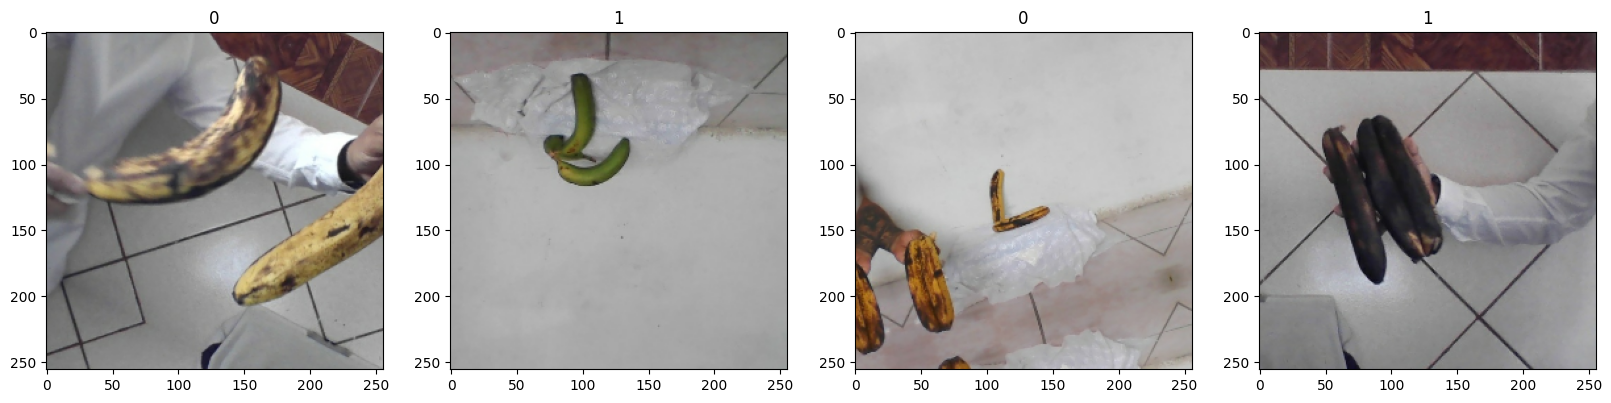

In [364]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int)) 
    ax[idx].title.set_text(batch[1][idx])

In [365]:
batch[0].shape

(32, 256, 256, 3)

# 4. Normalizar los datos

In [10]:
data = data.map(lambda x,y: (x/255, y))

In [11]:
data.as_numpy_iterator().next()

(array([[[[0.6431373 , 0.6431373 , 0.6431373 ],
          [0.63504905, 0.63504905, 0.63504905],
          [0.63284314, 0.63284314, 0.625     ],
          ...,
          [0.51870406, 0.5226256 , 0.5383119 ],
          [0.5110294 , 0.5267157 , 0.5384804 ],
          [0.5058824 , 0.5176471 , 0.5372549 ]],
 
         [[0.64260113, 0.64260113, 0.64260113],
          [0.6340686 , 0.6340686 , 0.6340686 ],
          [0.63434434, 0.63434434, 0.63434434],
          ...,
          [0.5156863 , 0.51960784, 0.527451  ],
          [0.50980395, 0.5254902 , 0.5372549 ],
          [0.50465685, 0.5203431 , 0.53210783]],
 
         [[0.63529414, 0.63529414, 0.63529414],
          [0.6360294 , 0.6360294 , 0.6360294 ],
          [0.63722426, 0.63722426, 0.63722426],
          ...,
          [0.5116575 , 0.5195006 , 0.51557904],
          [0.5068781 , 0.52256435, 0.5264859 ],
          [0.4990196 , 0.5147059 , 0.51862746]],
 
         ...,
 
         [[0.598606  , 0.5946844 , 0.57899815],
          [0.59607

In [12]:
data

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# 5. Dividir el dataset en particiones de entrenamiento, validación y prueba

In [345]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [346]:
train_size

105

In [347]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [348]:
val

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# 6. Construcción del modelo CNN

In [335]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [388]:
cnn = Sequential()

In [389]:
cnn.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(16, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Flatten())
cnn.add(Dropout(0.5))
cnn.add(Dense(2048, activation='relu'))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

In [390]:
cnn.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [391]:
cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 30, 30, 32)      

In [102]:
#model = Sequential()

In [103]:
#model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#model.add(MaxPooling2D())
#model.add(Conv2D(32, (3,3), 1, activation='relu'))
#model.add(MaxPooling2D())
#model.add(Conv2D(16, (3,3), 1, activation='relu'))
#model.add(MaxPooling2D())
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))

In [104]:
#model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# 7. Entrenamiento

In [170]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [171]:
hist = cnn.fit(train, epochs=150, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/150
105/105 [==============================] - 7s 57ms/step - loss: 0.6319 - accuracy: 0.6193 - val_loss: 0.1762 - val_accuracy: 0.9312
Epoch 2/150
105/105 [==============================] - 6s 58ms/step - loss: 0.1406 - accuracy: 0.9479 - val_loss: 0.0890 - val_accuracy: 0.9708
Epoch 3/150
105/105 [==============================] - 6s 56ms/step - loss: 0.0969 - accuracy: 0.9634 - val_loss: 0.0691 - val_accuracy: 0.9771
Epoch 4/150
105/105 [==============================] - 6s 56ms/step - loss: 0.0774 - accuracy: 0.9723 - val_loss: 0.0805 - val_accuracy: 0.9719
Epoch 5/150
105/105 [==============================] - 6s 56ms/step - loss: 0.0584 - accuracy: 0.9771 - val_loss: 0.0387 - val_accuracy: 0.9865
Epoch 6/150
105/105 [==============================] - 6s 57ms/step - loss: 0.0495 - accuracy: 0.9833 - val_loss: 0.0635 - val_accuracy: 0.9781
Epoch 7/150
105/105 [==============================] - 6s 58ms/step - loss: 0.0337 - accuracy: 0.9878 - val_loss: 0.0309 - val_accuracy:

105/105 [==============================] - 6s 59ms/step - loss: 0.0174 - accuracy: 0.9949 - val_loss: 0.0337 - val_accuracy: 0.9896
Epoch 58/150
105/105 [==============================] - 6s 57ms/step - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.0268 - val_accuracy: 0.9958
Epoch 59/150
105/105 [==============================] - 6s 57ms/step - loss: 0.0056 - accuracy: 0.9994 - val_loss: 0.0319 - val_accuracy: 0.9927
Epoch 60/150
105/105 [==============================] - 6s 57ms/step - loss: 0.0139 - accuracy: 0.9964 - val_loss: 0.0382 - val_accuracy: 0.9896
Epoch 61/150
105/105 [==============================] - 6s 56ms/step - loss: 0.0102 - accuracy: 0.9973 - val_loss: 0.0190 - val_accuracy: 0.9948
Epoch 62/150
105/105 [==============================] - 6s 58ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0279 - val_accuracy: 0.9937
Epoch 63/150
105/105 [==============================] - 7s 64ms/step - loss: 3.5776e-04 - accuracy: 0.9997 - val_loss: 0.0256 - val_accuracy: 0

105/105 [==============================] - 7s 61ms/step - loss: 0.0012 - accuracy: 0.9988 - val_loss: 0.0584 - val_accuracy: 0.9937
Epoch 114/150
105/105 [==============================] - 7s 64ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0086 - val_accuracy: 0.9990
Epoch 115/150
105/105 [==============================] - 7s 67ms/step - loss: 6.3835e-04 - accuracy: 0.9997 - val_loss: 0.0082 - val_accuracy: 0.9990
Epoch 116/150
105/105 [==============================] - 6s 59ms/step - loss: 5.5605e-06 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 0.9990
Epoch 117/150
105/105 [==============================] - 6s 58ms/step - loss: 3.3658e-05 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 0.9979
Epoch 118/150
105/105 [==============================] - 6s 57ms/step - loss: 8.8303e-06 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy: 0.9969
Epoch 119/150
105/105 [==============================] - 6s 56ms/step - loss: 6.5452e-06 - accuracy: 1.0000 - val_loss: 0.

In [276]:
hist.history

{'loss': [0.6318767666816711,
  0.14059655368328094,
  0.09686444699764252,
  0.07740518450737,
  0.05843424052000046,
  0.04951203241944313,
  0.03371114283800125,
  0.01908380165696144,
  0.024226464331150055,
  0.013296157121658325,
  0.006123220548033714,
  0.0024751173332333565,
  0.0004986299900338054,
  0.045251719653606415,
  0.15872357785701752,
  0.12240925431251526,
  0.06381597369909286,
  0.03887423127889633,
  0.03581487759947777,
  0.013907987624406815,
  0.012105979956686497,
  0.01967035047709942,
  0.010393976233899593,
  0.001206231419928372,
  0.0003801221610046923,
  0.004542889539152384,
  0.001619447604753077,
  0.009298156015574932,
  0.011201766319572926,
  0.0684964507818222,
  0.010989109985530376,
  0.004469662439078093,
  0.001182447886094451,
  0.001523687969893217,
  0.1407596915960312,
  0.04356441646814346,
  0.04139203205704689,
  0.03139866143465042,
  0.021666673943400383,
  0.019768934696912766,
  0.014638670720160007,
  0.02364196628332138,
  0.014

# 8. Graficar Desempeño

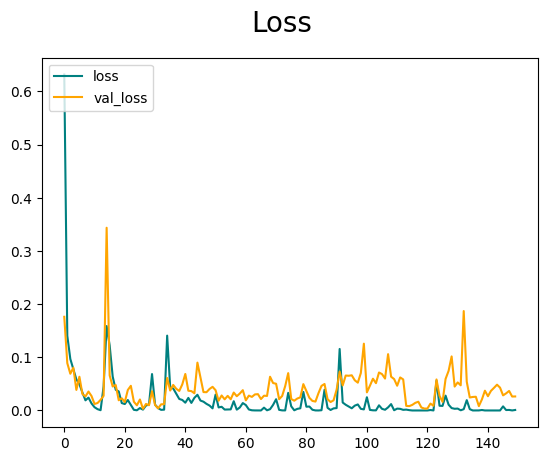

In [277]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

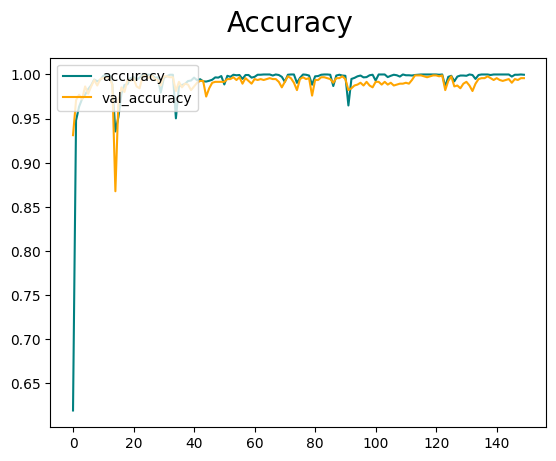

In [278]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [401]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [402]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [407]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = cnn.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 32ms/step


In [408]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.50208336, shape=(), dtype=float32)


In [409]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{ acc.result().numpy()}')

Precision:0.0, Recall:0.0, Accuracy:0.5020833611488342


# 10. Test

In [394]:
import cv2

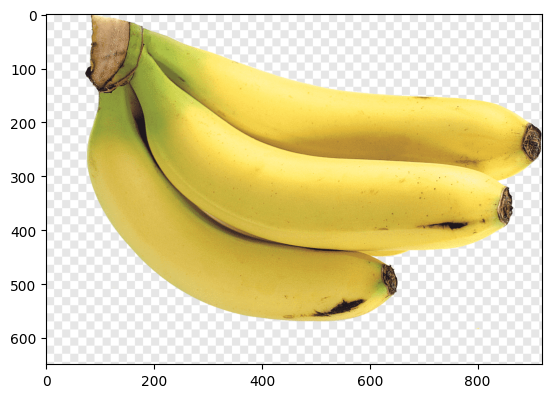

In [395]:
img = cv2.imread('png-transparent-cooking-banana-desktop-fruit-green-banana-food-fruit-desktop-wallpaper.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

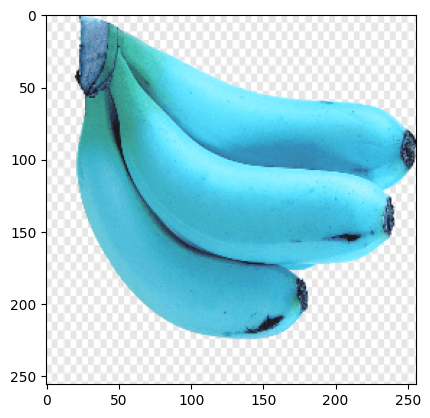

In [396]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [397]:
yhat = cnn.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 17ms/step


In [398]:
yhat

array([[0.4388662]], dtype=float32)

In [399]:
yhat[0][0:2]

array([0.4388662], dtype=float32)

In [400]:
if yhat > 0.5: 
    print(f'No cumple con la NTP N°011.005(2009)')
else:
    print(f'Cumple con la NTP N°011.005(2009)')

Cumple con la NTP N°011.005(2009)


# 11. Save the Model

In [371]:
from tensorflow.keras.models import load_model

In [372]:
model.save(os.path.join('models','cnn_0.h5'))

In [374]:
new_model = load_model('models/cnn_0.h5')

In [375]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 163ms/step


array([[1.]], dtype=float32)